<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install -U sentence-transformers
!pip install flaml

In [2]:
from sentence_transformers import SentenceTransformer
from flaml import AutoML
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import classification_report, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import markdown
import lxml
from bs4 import BeautifulSoup
import re
import time
import pickle
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#Imports:

# Clasification model
with open('/content/drive/MyDrive/GHDomains/Resources/automl.pkl', 'rb') as fp:
  automl = pickle.load(fp)
# Label encoder
with open('/content/drive/MyDrive/GHDomains/Resources/label_encoder.pkl', 'rb') as fp:
  le = pickle.load(fp)
# Num scaler
with open('/content/drive/MyDrive/GHDomains/Resources/num_scaler.pkl', 'rb') as fp:
  scaler = pickle.load(fp)
# Column names
with open('/content/drive/MyDrive/GHDomains/Resources/column_names.pkl', 'rb') as fp:
  column_names = pickle.load(fp)

In [ ]:
new_popular_df = pd.read_csv('/content/drive/MyDrive/GHDomains/New_popular_download/all_repos.csv')
new_popular_df = new_popular_df.rename(columns={"README": "Readme"}) 
new_popular_df

Name  \
0                     vuejs/devtools   
1    futurice/android-best-practices   
2    microsoft/Web-Dev-For-Beginners   
3             airbnb/react-sketchapp   
4               eugeneyan/applied-ml   
..                               ...   
888               graphql/dataloader   
889                 junyanz/CycleGAN   
890                     Tencent/wcdb   
891          halfrost/Halfrost-Field   
892                 hackjutsu/Lepton   

                                           Description  \
0    ‚öôÔ∏è Browser devtools extension for debugging Vu...   
1    Do's and Don'ts for Android development, by Fu...   
2    24 Lessons, 12 Weeks, Get Started as a Web Dev...   
3                render React components to Sketch ‚öõÔ∏èüíé   
4    üìö Papers & tech blogs by companies sharing the...   
..                                                 ...   
888  DataLoader is a generic utility to be used as ...   
889  Software that can generate photos from paintin...   
890  WCDB is a cross-platform database framework de...   
891                ‚úçüèª ËøôÈáåÊòØÂÜôÂçöÂÆ¢ÁöÑÂú∞Êñπ ‚Äî‚Äî Halfrost-Field ÂÜ∞Èúú‰πãÂú∞   
892  üíª     Democratizing Snippet Management (macOS/...   

                                                Readme  \
0    # vue-devtools\n\n![screenshot](./media/screen...   
1    # Best practices in Android development\n\nAvo...   
2    [![GitHub license](https://img.shields.io/gith...   
3    <div align="center">\n  <img alt="react-sketch...   
4    # applied-ml\nCurated papers, articles, and bl...   
..                                                 ...   
888  # DataLoader\n\nDataLoader is a generic utilit...   
889  <img src='imgs/horse2zebra.gif' align="right" ...   
890  # WCDB\n\n[![PRs Welcome](https://img.shields....   
891  # Halfrost-Field ÂÜ∞Èúú‰πãÂú∞\n\n<p align='center'>\n<...   
892  > **To Lepton users around the world in more t...   

                                                Labels  \
0    ['accepted proposition', 'bug', 'cannot reprod...   
1    ['2018', 'answered', 'bug', 'discussion', 'dup...   
2    ['bug', 'dependencies', 'documentation', 'dupl...   
3    ['awaiting-review', 'bug', 'chore', 'discuss',...   
4    ['bug', 'documentation', 'duplicate', 'enhance...   
..                                                 ...   
888  ['bug', 'dependencies', 'duplicate', 'enhancem...   
889  ['bug', 'duplicate', 'enhancement', 'help want...   
890  ['bug', 'duplicate', 'enhancement', 'help want...   
891  ['bug', 'duplicate', 'enhancement', 'help want...   
892  ['3rd party', 'bug', 'CI', 'dev', 'discussion'...   

                                          Contributors  \
0    ['Akryum', 'yyx990803', 'posva', 'bartlomieju'...   
1    ['staltz', 'peter-tackage', 'minsoopark', 'and...   
2    ['jlooper', 'ManuSquall', 'San1ay', 'silversky...   
3    ['jongold', 'mathieudutour', 'macintoshhelper'...   
4    ['eugeneyan', 'shreyansh26', 'chmnsk', 'nilesh...   
..                                                 ...   
888  ['leebyron', 'wincent', 'gajus', 'brianwarner'...   
889  ['junyanz', 'taesungp', 'aferriss', 'asturur',...   
890  ['RingoD', 'John-He-928', 'infinnie', 'drakeet...   
891                  ['halfrost', 'somnus-L', 'devSC']   
892  ['hackjutsu', 'allcontributors[bot]', 'DNLHC',...   

                                             Languages  \
0    ['TypeScript', 'Vue', 'JavaScript', 'HTML', 'S...   
1                                                  NaN   
2                 ['JavaScript', 'HTML', 'CSS', 'Vue']   
3                         ['TypeScript', 'JavaScript']   
4                                                  NaN   
..                                                 ...   
888                            ['JavaScript', 'Shell']   
889                  ['Lua', 'Python', 'Shell', 'TeX']   
890  ['C', 'C++', 'Java', 'Swift', 'Objective-C++',...   
891  ['Go', 'CSS', 'Jupyter Notebook', 'Objective-C...   
892                     ['JavaScript', 'SCSS', 'HTML']   

      

In [4]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
def join_words_from_lists(text, join=False):
  text = str(text)
  if text == 'nan':
    return ''
  else:
    text = text[1:-1]
    text = text.replace('\'','')
    text = text.split(',')
    if join:
      text = ' '.join([word.strip() for word in text])
    return text

def clean_htmltags(text):
    html = markdown.markdown(text)                                # convert the code to html
    soup = BeautifulSoup(html, "lxml")                            # html.parser #XML stands for "eXtensible Markup Language",
    
    [s.extract() for s in soup(['iframe', 'script'])]             # eliminate html tags 
    stripped_text = soup.get_text()                               # get the rest of the text
    stripped_text = re.sub(r'[\r|\n|\r\n]+', ' ', stripped_text)  # delete remaining tags
    text = stripped_text                                          # voila!
                                    
    return text

def vectorize_categorical(df_Serie, prefix):
    lp_index = df_Serie.index

    vect = CountVectorizer(tokenizer=join_words_from_lists)
    lp_Serie = vect.fit_transform(df_Serie.astype(str))

    lp_Serie = pd.DataFrame(lp_Serie.toarray(), columns=vect.get_feature_names_out(), index=lp_index).add_prefix(prefix)
    lp_Serie = lp_Serie.astype(pd.SparseDtype(np.int64))
    return lp_Serie

In [6]:
def fit_transform(df, selected_features):

  # Apply text pre-processing
  df['Labels'] = df['Labels'].apply(lambda x: join_words_from_lists(x, join=True))
  df['Readme'] = df['Readme'].astype(str)
  df['Readme'] = pd.Series([clean_htmltags(x) for x in df['Readme']]) #df['Readme'].apply(lambda x: clean_htmltags(x)) #
  df['Readme'] = df['Readme'].apply(lambda x: re.sub('\s{2,}', " ", x))
  df['Description'] = df['Description'].astype(str)
  df['Description'] = df['Description'].replace('nan','')
  df['Text_data']   = df['Description'] + df['Readme'] + df['Labels']
  transformed_df = model.encode(df['Text_data'].to_list())

  # Vectorise categorical features
  cn_vect = vectorize_categorical(df['Contributors'], 'cn: ')
  pl_vect = vectorize_categorical(df['Languages'], 'pl: ')
  tp_vect = vectorize_categorical(df['Topics'], 'tp: ')
  ct_vect = vectorize_categorical(df['Contents'], 'ct: ')
  li_vect = vectorize_categorical(df['Licence'], 'li: ')

  # transform numbers of stars, forks y releases
  num_vectors = df[['Stars','Forks', 'Releases']].astype(np.float64)
  num_columns = num_vectors.columns
  num_index = num_vectors.index
  num_vectors = scaler.transform(num_vectors)
  num_vectors = pd.DataFrame(num_vectors, columns=num_columns, index=num_index)

  # Concat the dataframe and filter the columns to plug into the model
  transformed_df = pd.DataFrame(transformed_df, index=df.index).add_prefix('Text ')
  transformed_df = pd.concat([transformed_df, cn_vect, pl_vect, tp_vect, ct_vect, li_vect, num_vectors], axis=1)
  transformed_df = transformed_df.reindex(columns=column_names, fill_value=0)

  return transformed_df

In [ ]:
transformed_df = fit_transform(df=new_popular_df, selected_features=column_names)
prediction = automl.predict(transformed_df.to_numpy())

In [ ]:
le.inverse_transform(prediction)

In [ ]:
new_popular_df['Predicted_labels'] = le.inverse_transform(prediction)
new_popular_df

Name  \
0                     vuejs/devtools   
1    futurice/android-best-practices   
2    microsoft/Web-Dev-For-Beginners   
3             airbnb/react-sketchapp   
4               eugeneyan/applied-ml   
..                               ...   
888               graphql/dataloader   
889                 junyanz/CycleGAN   
890                     Tencent/wcdb   
891          halfrost/Halfrost-Field   
892                 hackjutsu/Lepton   

                                           Description  \
0    ‚öôÔ∏è Browser devtools extension for debugging Vu...   
1    Do's and Don'ts for Android development, by Fu...   
2    24 Lessons, 12 Weeks, Get Started as a Web Dev...   
3                render React components to Sketch ‚öõÔ∏èüíé   
4    üìö Papers & tech blogs by companies sharing the...   
..                                                 ...   
888  DataLoader is a generic utility to be used as ...   
889  Software that can generate photos from paintin...   
890  WCDB is a cross-platform database framework de...   
891                ‚úçüèª ËøôÈáåÊòØÂÜôÂçöÂÆ¢ÁöÑÂú∞Êñπ ‚Äî‚Äî Halfrost-Field ÂÜ∞Èúú‰πãÂú∞   
892  üíª     Democratizing Snippet Management (macOS/...   

                                                Readme  \
0    vue-devtools Documentation Install the extensi...   
1    Best practices in Android development Avoid re...   
2     Web Development for Beginners - A Curriculum ...   
3     render React components to Sketch; tailor-mad...   
4    applied-ml Curated papers, articles, and blogs...   
..                                                 ...   
888  DataLoader DataLoader is a generic utility to ...   
889   CycleGAN PyTorch project page paper Torch imp...   
890  WCDB ‰∏≠ÊñáÁâàÊú¨ËØ∑ÂèÇÁúãËøôÈáå WCDB is an efficient, complete,...   
891  Halfrost-Field ÂÜ∞Èúú‰πãÂú∞ ‚≠êÔ∏è ‰∏∫‰ªÄ‰πàË¶ÅÂª∫Ëøô‰∏™‰ªìÂ∫ì ‰∏ñ‰∫∫ÈÉΩËØ¥ÈòÖËØªÂºÄÊ∫êÊ°ÜÊû∂ÁöÑÊ∫ê‰ª£...   
892   To Lepton users around the world in more than...   

                                                Labels  \
0    accepted proposition bug cannot reproduce cont...   
1    2018 answered bug discussion duplicate enhance...   
2    bug dependencies documentation duplicate enhan...   
3    awaiting-review bug chore discuss docs duplica...   
4    bug documentation duplicate enhancement good f...   
..                                                 ...   
888  bug dependencies duplicate enhancement help wa...   
889  bug duplicate enhancement help wanted invalid ...   
890  bug duplicate enhancement help wanted invalid ...   
891  bug duplicate enhancement help wanted invalid ...   
892  3rd party bug CI dev discussion duplicate enha...   

                                          Contributors  \
0    ['Akryum', 'yyx990803', 'posva', 'bartlomieju'...   
1    ['staltz', 'peter-tackage', 'minsoopark', 'and...   
2    ['jlooper', 'ManuSquall', 'San1ay', 'silversky...   
3    ['jongold', 'mathieudutour', 'macintoshhelper'...   
4    ['eugeneyan', 'shreyansh26', 'chmnsk', 'nilesh...   
..                                                 ...   
888  ['leebyron', 'wincent', 'gajus', 'brianwarner'...   
889  ['junyanz', 'taesungp', 'aferriss', 'asturur',...   
890  ['RingoD', 'John-He-928', 'infinnie', 'drakeet...   
891                  ['halfrost', 'somnus-L', 'devSC']   
892  ['hackjutsu', 'allcontributors[bot]', 'DNLHC',...   

                                             Languages  \
0    ['TypeScript', 'Vue', 'JavaScript', 'HTML', 'S...   
1                                                  NaN   
2                 ['JavaScript', 'HTML', 'CSS', 'Vue']   
3                         ['TypeScript', 'JavaScript']   
4                                                  NaN   
..                                                 ...   
888                            ['JavaScript', 'Shell']   
889                  ['Lua', 'Python', 'Shell', 'TeX']   
890  ['C', 'C++', 'Java', 'Swift', 'Objective-C++',...   
891  ['Go', 'CSS', 'Jupyter Notebook', 'Objective-C...   

In [ ]:
new_popular_df.to_csv('/content/drive/MyDrive/GHDomains/Resources/new_popular_df_predicted.csv', index=False)

In [7]:
less_popular_df = pd.read_csv('/content/drive/MyDrive/GHDomains/Resources/less_popular_df_predicted.csv')
less_popular_df = less_popular_df.rename(columns={"README": "Readme"}) 
less_popular_df

Name  \
0            yetanother-blog/indiepen   
1           SnowdogApps/magento2-menu   
2                   api-platform/demo   
3      rroemhild/docker-test-openldap   
4                    ikostrikov/jaxrl   
..                                ...   
94                     noib3/dotfiles   
95                     ntucker/anansi   
96           googleapis/java-bigtable   
97                       hotio/sonarr   
98  open-telemetry/opentelemetry-ruby   

                                          Description  \
0   An independent and privacy-friendly solution t...   
1   Provides powerful menu editor to replace categ...   
2             Demo app for the API Platform framework   
3   Docker OpenLDAP Server for testing LDAP applic...   
4   JAX (Flax) implementation of algorithms for De...   
..                                                ...   
94  :house: Procrastinating has never felt this pr...   
95  React web applications for perfectionists with...   
96                                                NaN   
97                                                NaN   
98     OpenTelemetry Ruby API & SDK, and related gems   

                                               Readme  \
0   # Indiepen üìù\n\n[![Netlify Status](https://api...   
1   [![Packagist](https://img.shields.io/packagist...   
2   <h1 align="center"><a href="https://api-platfo...   
3   # OpenLDAP Docker Image for testing\n\n![Docke...   
4   [![DOI](https://zenodo.org/badge/330059679.svg...   
..                                                ...   
94  # :european_castle: dotfiles\n\nThis repositor...   
95  # üï∑ Anansi\n\n> Production ready, developer fr...   
96  # Google Cloud Bigtable Client for Java\n\nJav...   
97  # Documentation\n\nAll our documentation is lo...   
98  # OpenTelemetry Ruby\n\n[![Slack channel][slac...   

                                               Labels  \
0   ['bug', 'depfu', 'documentation', 'duplicate',...   
1   ['awaiting release', 'bug', 'dependencies', 'd...   
2   ['bug', 'dependencies', 'duplicate', 'easy pic...   
3   ['bug', 'duplicate', 'enhancement', 'help want...   
4   ['bug', 'documentation', 'duplicate', 'enhance...   
..                                                ...   
94  ['bug', 'documentation', 'duplicate', 'enhance...   
95  ['bug', 'dependencies', 'duplicate', 'enhancem...   
96  [':rotating_light:', 'api: bigtable', 'automer...   
97  ['bug', 'dependencies', 'duplicate', 'enhancem...   
98  ['bug', 'dependencies', 'duplicate', 'enhancem...   

                                         Contributors  \
0   ['HenrikFricke', 'depfu[bot]', 'andrew-secret'...   
1   ['akai-z', 'Igloczek', 'talalus', 'dawiddczaja...   
2   ['vincentchalamon', 'dunglas', 'pborreli', 'al...   
3   ['rroemhild', 'AnalogJ', 'rbarbey', 'Chocobozz...   
4                      ['ikostrikov', 'erwincoumans']   
..                                                ...   
94                                          ['noib3']   
95  ['ntucker', 'dependabot[bot]', 'renovate[bot]'...   
96  ['renovate-bot', 'yoshi-automation', 'igorbern...   
97  ['mrhotio', 'dependabot[bot]', 'actions-user',...   
98  ['fbogsany', 'robertlaurin', 'github-actions[b...   

                                            Languages  \
0         ['HTML', 'JavaScript', 'CSS', 'TypeScript']   
1        ['JavaScript', 'PHP', 'Vue', 'Less', 'HTML']   
2   ['TypeScript', 'PHP', 'Shell', 'Dockerfile', '...   
3                                      ['Dockerfile']   
4   ['Jupyter Notebook', 'Python', 'Dockerfile', '...   
..                                                ...   
94  ['Nix', 'Lua', 'Python', 'CSS', 'Shell', 'Vim ...   
95  ['JavaScript', 'TypeScript', 'Smarty', 'SCSS',...   
96           ['Java', 'Shell', 'Python', 'Batchfile']   
97                                                NaN   
98  ['Ruby', 'Thrift', 'HTML', 'Dockerfile', 'Jinj...   

                                               Topics  \
0   ['cookieless', 'accessible', 'performant', 'in..

In [8]:
transformed_df = fit_transform(df=less_popular_df, selected_features=column_names)
prediction = automl.predict(transformed_df.to_numpy())
le.inverse_transform(prediction)

array(['Web libraries and frameworks', 'Web libraries and frameworks',
       'Web libraries and frameworks', 'Software tools',
       'Non-web libraries and frameworks', 'Documentation',
       'Application & System software',
       'Non-web libraries and frameworks', 'Software tools',
       'Web libraries and frameworks', 'Software tools',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Software tools', 'Software tools', 'Software tools',
       'Software tools', 'Software tools',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Non-web libraries and frameworks',
       'Application & System software', 'Web libraries and frameworks',
       'Non-web libraries and frameworks', 'Web libraries and framewor

In [9]:
less_popular_df['Predicted_labels'] = le.inverse_transform(prediction)
less_popular_df

Name  \
0            yetanother-blog/indiepen   
1           SnowdogApps/magento2-menu   
2                   api-platform/demo   
3      rroemhild/docker-test-openldap   
4                    ikostrikov/jaxrl   
..                                ...   
94                     noib3/dotfiles   
95                     ntucker/anansi   
96           googleapis/java-bigtable   
97                       hotio/sonarr   
98  open-telemetry/opentelemetry-ruby   

                                          Description  \
0   An independent and privacy-friendly solution t...   
1   Provides powerful menu editor to replace categ...   
2             Demo app for the API Platform framework   
3   Docker OpenLDAP Server for testing LDAP applic...   
4   JAX (Flax) implementation of algorithms for De...   
..                                                ...   
94  :house: Procrastinating has never felt this pr...   
95  React web applications for perfectionists with...   
96                                                      
97                                                      
98     OpenTelemetry Ruby API & SDK, and related gems   

                                               Readme  \
0   Indiepen üìù An independent and privacy-friendly...   
1    Magento 2 Menu Provides powerful menu editor ...   
2    This application is a demonstration for the A...   
3   OpenLDAP Docker Image for testing This image p...   
4    JAX (Flax) RL This repository contains JAX (F...   
..                                                ...   
94  :european_castle: dotfiles This repository con...   
95  üï∑ Anansi Production ready, developer friendly....   
96  Google Cloud Bigtable Client for Java Java idi...   
97  Documentation All our documentation is located...   
98  OpenTelemetry Ruby The Ruby OpenTelemetry clie...   

                                               Labels  \
0   bug depfu documentation duplicate embed enhanc...   
1   awaiting release bug dependencies duplicate en...   
2   bug dependencies duplicate easy pick enhanceme...   
3   bug duplicate enhancement help wanted invalid ...   
4   bug documentation duplicate enhancement good f...   
..                                                ...   
94  bug documentation duplicate enhancement good f...   
95  bug dependencies duplicate enhancement feature...   
96  :rotating_light: api: bigtable automerge autom...   
97  bug dependencies duplicate enhancement good fi...   
98  bug dependencies duplicate enhancement good fi...   

                                         Contributors  \
0   ['HenrikFricke', 'depfu[bot]', 'andrew-secret'...   
1   ['akai-z', 'Igloczek', 'talalus', 'dawiddczaja...   
2   ['vincentchalamon', 'dunglas', 'pborreli', 'al...   
3   ['rroemhild', 'AnalogJ', 'rbarbey', 'Chocobozz...   
4                      ['ikostrikov', 'erwincoumans']   
..                                                ...   
94                                          ['noib3']   
95  ['ntucker', 'dependabot[bot]', 'renovate[bot]'...   
96  ['renovate-bot', 'yoshi-automation', 'igorbern...   
97  ['mrhotio', 'dependabot[bot]', 'actions-user',...   
98  ['fbogsany', 'robertlaurin', 'github-actions[b...   

                                            Languages  \
0         ['HTML', 'JavaScript', 'CSS', 'TypeScript']   
1        ['JavaScript', 'PHP', 'Vue', 'Less', 'HTML']   
2   ['TypeScript', 'PHP', 'Shell', 'Dockerfile', '...   
3                                      ['Dockerfile']   
4   ['Jupyter Notebook', 'Python', 'Dockerfile', '...   
..                                                ...   
94  ['Nix', 'Lua', 'Python', 'CSS', 'Shell', 'Vim ...   
95  ['JavaScript', 'TypeScript', 'Smarty', 'SCSS',...   
96           ['Java', 'Shell', 'Python', 'Batchfile']   
97                                                NaN   
98  ['Ruby', 'Thrift', 'HTML', 'Dockerfile', 'Jinj...   

                                               Topics  \
0   ['cookieless', 'accessible', 'performant', 'in..

In [26]:
print(classification_report(less_popular_df['True_label'], less_popular_df['Predicted_labels'], target_names=le.classes_))

                                  precision    recall  f1-score   support

   Application & System software       0.38      0.20      0.26        25
                   Documentation       0.07      0.50      0.12         2
Non-web libraries and frameworks       0.50      0.61      0.55        23
                  Software tools       0.52      0.52      0.52        27
    Web libraries and frameworks       0.71      0.55      0.62        22

                        accuracy                           0.46        99
                       macro avg       0.44      0.47      0.41        99
                    weighted avg       0.51      0.46      0.47        99



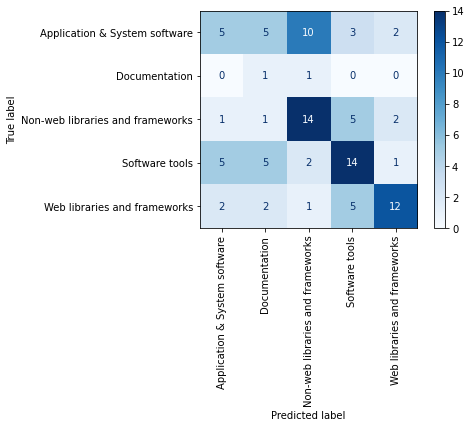

In [28]:
cnf_matrix = confusion_matrix(less_popular_df['True_label'], less_popular_df['Predicted_labels'])
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=le.classes_).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

In [ ]:
less_popular_df.to_csv('/content/drive/MyDrive/GHDomains/Resources/less_popular_df_predicted.csv', index=False)